## Exercise 5.2: Build Your Own Sentiment Analysis Model

### You will build a model with the movie reviews dataset that you worked with in Week 3: Bag of Words Meets Bags of Popcorn. 
1. Get the stemmed data using the same process you did in Week 3.
2. Split this into a training and test set.
3. Fit and apply the tf-idf vectorization to the training set.
4. Apply but DO NOT FIT the tf-idf vectorization to the test set (Why?).
5. Train a logistic regression using the training data.
6. Find the model accuracy on the test set.
7. Create a confusion matrix for the test set predictions.
8. Get the precision, recall, and F1-score for the test set predictions.
9. Create a ROC curve for the test set.
10. Pick another classification model you learned about this week and repeat steps (5) – (9).

In [7]:
# Import required packages

import pandas as pd 
import numpy as np
import re as re
from textblob import TextBlob
from textblob.classifiers import NaiveBayesClassifier
import nltk
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
import html
from nltk.stem import PorterStemmer

1. Get the stemmed data using the same process you did in Week 3.

In [2]:
#Loading tsv data into data frame
trainData = pd.read_csv('labeledTrainData.tsv.zip', delimiter="\t")
trainData.head()

,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0,It must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...


In [3]:
# Shape of the trainData
trainData.shape

(25000, 3)

In [4]:
# Checking counts of positive and negative reviews
print("Number of rows in the train data set with positive reviews are :", sum(trainData['sentiment'] == 1))
print("Number of rows in the train data set with Negative reviews in dataset :", sum(trainData['sentiment'] == 0))

Number of rows in the train data set with positive reviews are : 12500
Number of rows in the train data set with Negative reviews in dataset : 12500


In [5]:
# creating function to clean text to clean the input text.
def clean_text(text):
    text = BeautifulSoup(text).get_text() #beautifying text
    letters_only = re.sub("[^a-zA-Z]", " ", text) # clean the html charecters (non text)
    words = letters_only.lower().split()   # convert to lower text                        
    stops = set(stopwords.words("english")) # setting stop words to remove                  
    main_words = [w for w in words if not w in stops]   
    return( " ".join( main_words )) 

In [6]:
# applying clean function on the data frame's review column and creating a new column with clean text in trainData frame
trainData['clean_review'] = trainData['review'].apply(clean_text)

In [8]:
trainData.head()

,id,sentiment,review,clean_review
0,5814_8,1,With all this stuff going down at the moment w...,stuff going moment mj started listening music ...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi...",classic war worlds timothy hines entertaining ...
2,7759_3,0,The film starts with a manager (Nicholas Bell)...,film starts manager nicholas bell giving welco...
3,3630_4,0,It must be assumed that those who praised this...,must assumed praised film greatest filmed oper...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...,superbly trashy wondrously unpretentious explo...


In [9]:
# Applying porterstemmer on clean_review
ps = PorterStemmer()
trainData['clean_review'] = trainData['clean_review'].apply(lambda review: ps.stem(review))

In [10]:
# importing word_tokenize
from nltk import word_tokenize 
# extracting and prinitng tokenized values sample
corpora = trainData['clean_review'].values
tokenized = [word_tokenize(corpus) for corpus in corpora]

print(tokenized[2222])

['go', 'immediately', 'rent', 'movie', 'bottom', 'shelf', 'local', 'video', 'store', 'covered', 'dust', 'one', 'touched', 'years', 'may', 'even', 'special', 'worth', 'ten', 'bucks', 'swear', 'buy', 'many', 'films', 'compare', 'celluloid', 'version', 'goo', 'forms', 'bottom', 'trash', 'years', 'yes', 'gave', 'really', 'deserves', 'much', 'lower', 'scales', 'designed', 'stuff', 'like', 'mind']


In [12]:
# shape of train data frame
trainData.shape

(25000, 4)

2. Split this into a training and test set

In [13]:
# import Necessary libraries
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import mean_squared_error

In [14]:
#Select Predictor columns
X = trainData[['id','clean_review']]

#Select target column
y = trainData['sentiment']

names = [
       'sentiment'
    , 'id', 'review'
]

In [15]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2)

3. Fit and apply the tf-idf vectorization to the training set.

In [16]:
# Creating bag_of_words matrix from clean review
count = CountVectorizer()
bag_of_words_train = count.fit_transform(X_train['clean_review'])

In [17]:
#Size of bag_of_words
bag_of_words_train 

<20000x68946 sparse matrix of type '<class 'numpy.int64'>'
	with 1952611 stored elements in Compressed Sparse Row format>

In [18]:
# Import tf-idf encoding from sklearn library
from sklearn.feature_extraction.text import TfidfVectorizer

# Define some hiperparameters of encoded
vectorizer = TfidfVectorizer()

# Create the training set with the words encoded as features of the reviews
train_data_features = vectorizer.fit_transform(X_train['clean_review'])

print(train_data_features.shape)

(20000, 68946)


It concludes the shape of train_data_features (20000, 68803) matches the bag_of_words(bag_of_words_train) shape.

4. Apply but DO NOT FIT the tf-idf vectorization to the test set (Why?).

In [19]:
#bag of words for test data.
bag_of_words_test = count.fit_transform(X_test['clean_review'])

In [20]:
#size of bag_of_words_test
bag_of_words_test

<5000x38768 sparse matrix of type '<class 'numpy.int64'>'
	with 493533 stored elements in Compressed Sparse Row format>

We didnt fit the tf-idf vectorization on test data, as we should be predicting the sentiment value - by applying the model we trained on train data but not on test data.

5. Train a logistic regression using the training data.

In [21]:
# Import the logistic regression model from sklearn 
from sklearn.linear_model import LogisticRegression

# Define the model
model = LogisticRegression(random_state=0, solver='lbfgs',
                            multi_class='multinomial')
# Train model
model.fit(train_data_features, y_train)

LogisticRegression(multi_class='multinomial', random_state=0)

6. Find the model accuracy on the test set.

In [22]:
# Read the test data

print(X_test.shape)


# Create the test set with the words encoded as features of the reviews
test_data_features_test = vectorizer.transform(X_test['clean_review'])


# Use the logistic regression model to make sentiment label predictions
result_lr = model.predict(test_data_features_test)

# Copy the results to a pandas dataframe with an "id" column and a "sentiment" column
output = pd.DataFrame( data={"id":X_test["id"],"sentiment_calc":result_lr,"train_sentiment":y_test})
output.head()

(5000, 2)


,id,sentiment_calc,train_sentiment
18054,5942_7,0,1
22903,5462_3,1,0
19510,12360_4,1,0
4842,2561_7,1,1
20604,10736_10,1,1


In [23]:
# Calculating positive and negative review sentiment analysis count by Logistics Regression
print("Number of rows in the data set with positive reviews in dataset per Logistics Regression model :", sum(output['sentiment_calc'] > 0))
print("Number of rows in the data set with Negative reviews in dataset per Logistics Regression model :", sum(output['sentiment_calc'] == 0))

Number of rows in the data set with positive reviews in dataset per Logistics Regression model : 2616
Number of rows in the data set with Negative reviews in dataset per Logistics Regression model : 2384


In [24]:
# Calculating positive and negative review sentiment analysis count by Logistics Regression
print("Number of rows in the data set with positive reviews in dataset per Logistics Regression model :", sum(output['sentiment_calc'] > 0))
print("Number of rows in the data set with Negative reviews in dataset per Logistics Regression model :", sum(output['sentiment_calc'] <= 0))

Number of rows in the data set with positive reviews in dataset per Logistics Regression model : 2616
Number of rows in the data set with Negative reviews in dataset per Logistics Regression model : 2384


In [25]:
# Calculating Accuracy of custom model where labelled test data and Logistics Regression prediction for sentiment are matching
print("Accurate positive sentiment prediction by Logistics Regression model :", sum((output['sentiment_calc'] == 1) & (output['train_sentiment'] == 1)))
print("Accurate negative sentiment prediction by Logistics Regression model :", sum((output['sentiment_calc'] == 0) & (output['train_sentiment'] == 0)))


Accurate positive sentiment prediction by Logistics Regression model : 2330
Accurate negative sentiment prediction by Logistics Regression model : 2155


Total number of agreements by custom model: 2330+2155 = 4485.
Total number of samples: 5000.
Accuracy of Logistics regression = (4485/5000)*100 = 89.7%.
Accuracy of Logistics regression is about 89.7%. This is definitely better than random guessing as it would be a 50% accurate model with either yes or no.

7. Create a confusion matrix for the test set predictions.

In [26]:
# confusion matrix
confusion_matrix = pd.crosstab(output['train_sentiment'], output['sentiment_calc'] , rownames=['Actual'], colnames=['Predicted'])
print (confusion_matrix)

Predicted     0     1
Actual               
0          2155   286
1           229  2330


8. Get the precision, recall, and F1-score for the test set predictions.

Precision = (True Positive)/(True Positive + False Positive) = 2330/(2330+286) = 2330/2616= 0.89
Recall = (True Positive)/(True Positive + False Negative) = 2330/(2330+229) = 2330/2559 = 0.91
F1-Score = 2((Precison*Recall)/(Precision + Recall)) = 2 ((0.89 * 0.91)/(0.89 + 0.91)) = 2 (0.809/1.80) = 0.898

9. Create a ROC curve for the test set.

In [27]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
%matplotlib inline

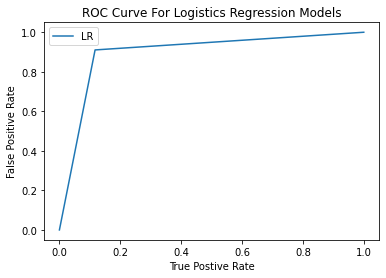

In [28]:
y_pred_list = [result_lr]
label_list = ["LR"]
pred_label = zip(y_pred_list, label_list)
for y_pred, lbl in pred_label:
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr, label = lbl)

plt.xlabel("True Postive Rate")
plt.ylabel("False Positive Rate")
plt.title("ROC Curve For Logistics Regression Models")
plt.legend()
plt.show()

10. Pick another classification model you learned about this week and repeat steps (5) – (9).

In [29]:
# Random Forest : Selected Random Forest Model.
# Load required libraries
from sklearn.ensemble import RandomForestClassifier
# Param Grid
param_grid = {'n_estimators':[x for x in range(100,1000)],'criterion':['gini', 'entropy'],'min_samples_split':[2,5,10],'min_samples_leaf':[2,5,10] }

In [30]:
# Vectorize Test data for new model
train_data_features_rf = vectorizer.fit_transform(X_train['clean_review'])

In [31]:
# Train a radius neighbors classifier
clf = RandomForestClassifier(n_estimators= 500)
clf.fit(train_data_features_rf,y_train)
print(clf.score(train_data_features_rf,y_train))

1.0


In [32]:
# Test Random Forest Model
# Read the test data
print(X_test.shape)
# Create the test set with the words encoded as features of the reviews
test_data_features_test_rf = vectorizer.transform(X_test['clean_review'])


# Use the logistic regression model to make sentiment label predictions
result_rf = clf.predict(test_data_features_test_rf)

# Copy the results to a pandas dataframe with an "id" column and a "sentiment" column
output_rf = pd.DataFrame( data={"id":X_test["id"],"sentiment_calc":result_rf,"train_sentiment":y_test})
output_rf.head()

(5000, 2)


,id,sentiment_calc,train_sentiment
18054,5942_7,0,1
22903,5462_3,1,0
19510,12360_4,1,0
4842,2561_7,1,1
20604,10736_10,1,1


In [33]:
#Calculating positive and negative review sentiment analysis count by RF
print("Number of rows in the data set with positive reviews in dataset per RF model :", sum(output_rf['sentiment_calc'] > 0))
print("Number of rows in the data set with Negative reviews in dataset per RF model :", sum(output_rf['sentiment_calc'] == 0))

Number of rows in the data set with positive reviews in dataset per RF model : 2540
Number of rows in the data set with Negative reviews in dataset per RF model : 2460


In [34]:
# Calculating Accuracy of custom model where labelled test data and RF prediction for sentiment are matching
print("Accurate positive sentiment prediction by RF model :", sum((output_rf['sentiment_calc'] == 1) & (output_rf['train_sentiment'] == 1)))
print("Accurate negative sentiment prediction by RF model :", sum((output_rf['sentiment_calc'] == 0) & (output_rf['train_sentiment'] == 0)))


Accurate positive sentiment prediction by RF model : 2200
Accurate negative sentiment prediction by RF model : 2101


Total number of agreements by custom model: 2200+2101 = 4301.
Total number of samples: 5000.
Accuracy of Logistics regression = (4301/5000)*100 = 86.02%.
Accuracy of Logistics regression is about 86.02%. This is definitely better than random guessing as it would be a 50% accurate model with either yes or no.

In [35]:
# Confusion Matrix for Random Forest model
confusion_matrix_rf = pd.crosstab(output_rf['train_sentiment'], output_rf['sentiment_calc'] , rownames=['Actual'], colnames=['Predicted'])
print (confusion_matrix_rf)

Predicted     0     1
Actual               
0          2101   340
1           359  2200


Precision = (True Positive)/(True Positive + False Positive) = 2200/(2200+340) = 2200/2540= 0.866
Recall = (True Positive)/(True Positive + False Negative) = 2200/(2200+359) = 2200/2559 = 0.859
F1-Score = 2((Precison * Recall)/(Precision + Recall)) = 2 ((0.866 * 0.859)/(0.866 + 0.859)) = 2 (0.743/1.725) = 0.861

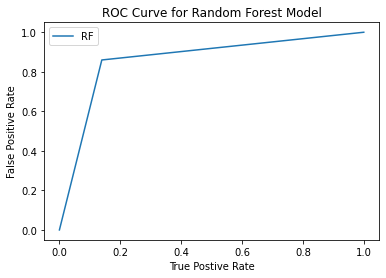

In [36]:
# ROC Curve for Random Forest
y_pred_list = [result_rf]
label_list = ["RF"]
pred_label = zip(y_pred_list, label_list)
for y_pred, lbl in pred_label:
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr, label = lbl)

plt.xlabel("True Postive Rate")
plt.ylabel("False Positive Rate")
plt.title("ROC Curve for Random Forest Model")
plt.legend()
plt.show()